In [16]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os
import cv2
import skimage.exposure
import pandas as pd

In [2]:
#DIR = os.path.join(HOME, 'programming', 'dk39')
DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/MD589'
INPUT = os.path.join(DIR, 'preps', 'CH1', 'thumbnail')
OUTPUT = os.path.join(DIR, 'preps', 'CH1', 'cleaned')
files = sorted(os.listdir(INPUT))

In [14]:
# convert to hsv
def flood(img, colors):
    # convert to hsv
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

    # threshold using inRange
    if sum(colors) > 100:
        range1 = (80,80,80)
        range2 = (93,93,93)
    else:
        range1 = (0,0,0)
        range2 = (3,3,3)
        
    mask = cv2.inRange(hsv,range1,range2)
    mask = 255 - mask

    # apply morphology opening to mask
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # antialias mask
    mask = cv2.GaussianBlur(mask, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)
    mask = skimage.exposure.rescale_intensity(mask, in_range=(127.5,255), out_range=(0,255))

    result = img.copy()
    result[mask==0] = colors
    return result

def place_image(img, max_width, max_height):
    zmidr = max_height // 2
    zmidc = max_width // 2
    startr = zmidr - (img.shape[0] // 2)
    endr = startr + img.shape[0]
    startc = zmidc - (img.shape[1] // 2)
    endc = startc + img.shape[1]
    new_img = np.ones([max_height, max_width]) * 240
    
    try:
        new_img[startr:endr,startc:endc] = img
    except:
        print('could not create new img', file, img.shape)
        
    return new_img.astype('uint8')


def find_main_blob(stats, image):
    height, width = image.shape
    df = pd.DataFrame(stats)
    df.columns = ['Left', 'Top', 'Width', 'Height', 'Area']
    df['blob_label'] = df.index
    df = df.sort_values(by='Area', ascending=False)

    for row in df.iterrows():
        Left = row[1]['Left']
        Top = row[1]['Top']
        Width = row[1]['Width']
        Height = row[1]['Height']
        corners = int(Left == 0) + int(Top == 0) + int(Width == width) + int(Height == height)
        if corners <= 2:
            return row


def scale_and_mask(src, mask, epsilon=0.01):
    vals = np.array(sorted(src[mask > 10]))
    ind = int(len(vals) * (1 - epsilon))
    _max = vals[ind]
    # print('thr=%d, index=%d'%(vals[ind],index))
    _range = 2 ** 8 - 1
    scaled = src * (200. / _max)
    scaled[scaled > _range] = _range
    scaled = scaled * (mask > 10)
    return scaled, _max



def find_threshold(src):
    fig = matplotlib.figure.Figure()
    ax = matplotlib.axes.Axes(fig, (0, 0, 0, 0))
    n, bins, patches = ax.hist(src.flatten(), 16);
    del ax, fig
    min_point = np.argmin(n[:5])
    min_point = int(min(2, min_point))
    thresh = (min_point * 12)
    return min_point, thresh

In [4]:
max_width = 1050
max_height = 1750
#max_width = 50100
#max_height = 34000
#1048x1738
#988x1624
#709x594
max_width = 1400
max_height = 900
#1038x747

In [5]:
print(max_width, max_height, len(files))

1400 900 225


In [6]:
dels = os.listdir(OUTPUT)
for d in dels:
    os.unlink(os.path.join(OUTPUT, d))

In [22]:
# get oriented for comparison
img_inputs = []
img_outputs = []
file_inputs = []
titles = []
for i, file in enumerate(tqdm(files[10:20])):
    infile = os.path.join(INPUT, file)
    src = cv2.imread(infile, cv2.IMREAD_GRAYSCALE)
    min_value, threshold = find_threshold(src)
    #print(src.shape)
    img_inputs.append(src)
    file_inputs.append(file)
    titles.append([min_value,threshold])
    #src = flood(src, (255,255,255))
    #src = flood(src, (0,0,0))
    threshold = 233
    ret, threshed = cv2.threshold(src, threshold, 255, cv2.THRESH_BINARY)
    threshed = np.uint8(threshed)
    ###### Find connected elements
    # You need to choose 4 or 8 for connectivity type
    connectivity = 4
    output = cv2.connectedComponentsWithStats(threshed, connectivity, cv2.CV_32S)
    # Get the results
    # The first cell is the number of labels
    num_labels = output[0]
    # The second cell is the label matrix
    labels = output[1]
    # The third cell is the stat matrix
    stats = output[2]
    # The fourth cell is the centroid matrix
    centroids = output[3]
    # Find the blob that corresponds to the section.
    row = find_main_blob(stats, img)
    blob_label = row[1]['blob_label']
    # extract the blob
    blob = np.uint8(labels == blob_label) * 255
    # Perform morphological closing
    kernel10 = np.ones((10, 10), np.uint8)
    closing = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel10, iterations=5)
    
    
    
    img_outputs.append(closing)
    #src = place_image(src, max_width, max_height)
    #outpath = os.path.join(OUTPUT, file)    
    #cv2.imwrite(outpath, src.astype('uint8'))
print('Finished')

100%|██████████| 10/10 [00:00<00:00, 41.91it/s]

Finished


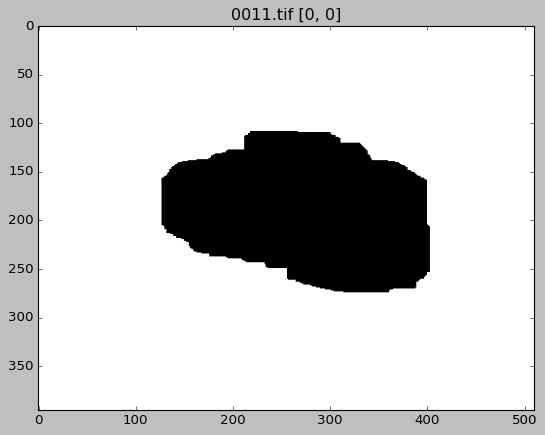

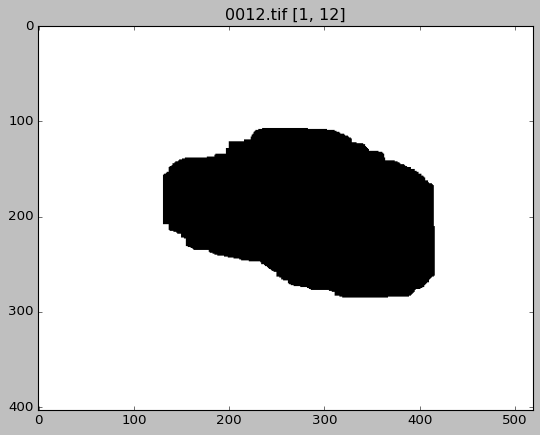

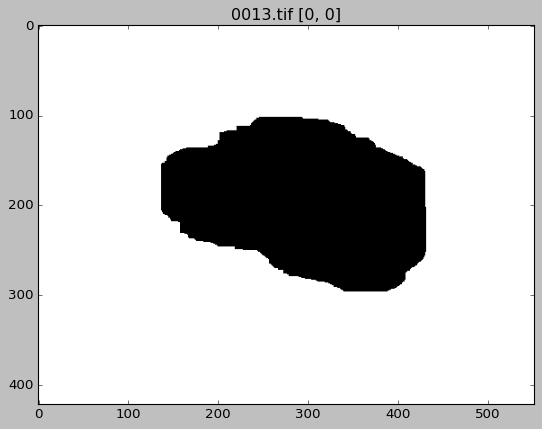

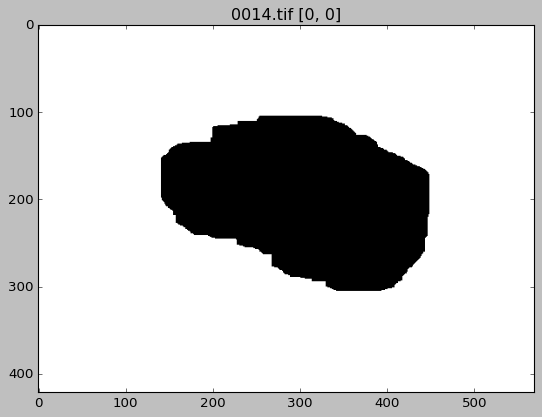

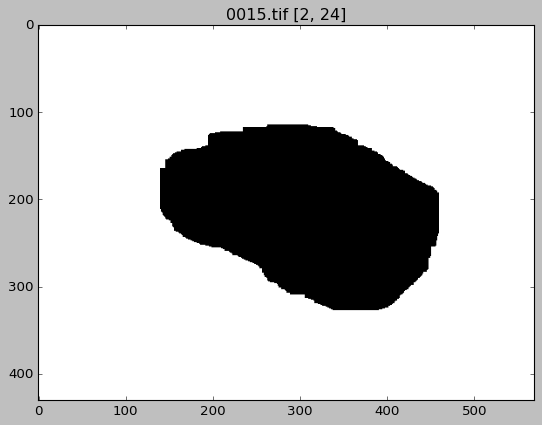

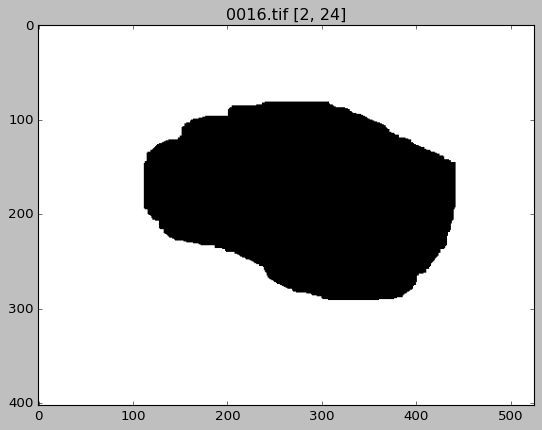

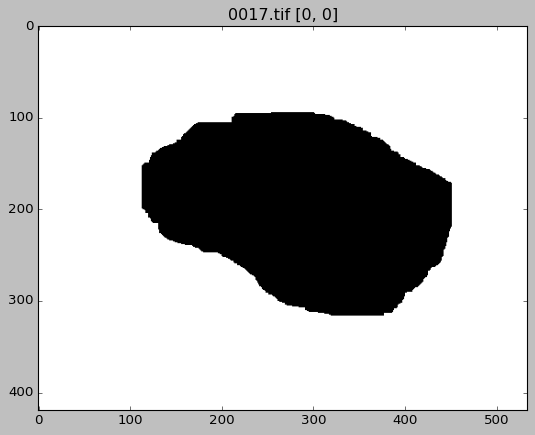

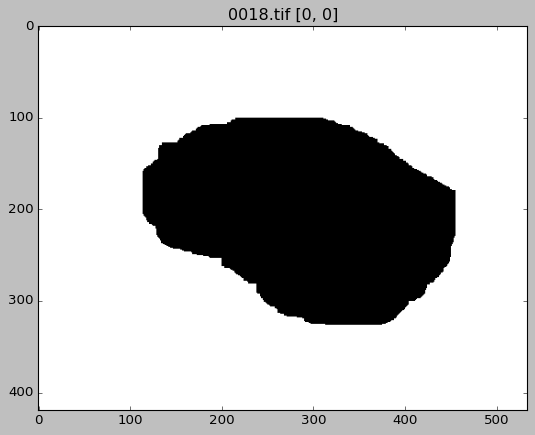

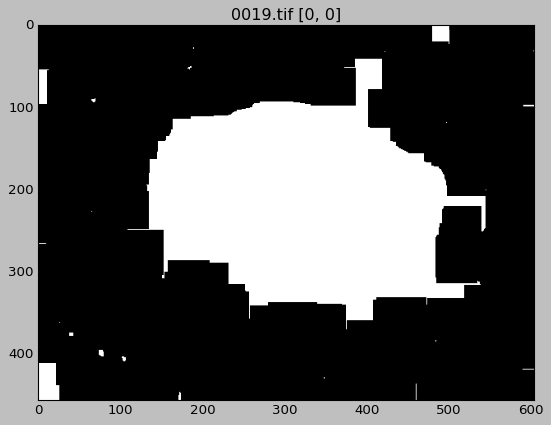

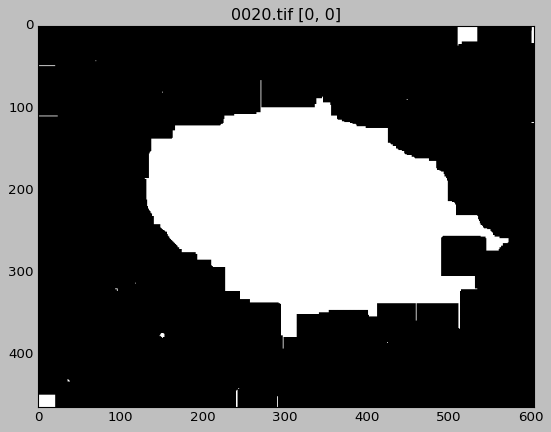

In [23]:
# display images
# check alignment
start, finish = (0,10)
#displays = masks[start:finish]
#displays = img_inputs[start:finish]
displays = img_outputs[start:finish]
tdisplays = titles[start:finish]
names = file_inputs[start:finish]
plt.style.use('classic')
for name,img,title in zip(names,displays, tdisplays):    
    plt.figure()
    plt.title('{} {}'.format(name, str(title)))
    #plt.title('{}'.format(name))
    plt.imshow(img, cmap='gray')
    plt.show()

In [ ]:
img = img_outputs[0]
orig = img_inputs[0]

# convert to hsv
hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

# threshold using inRange
range1 = (0,0,0)
range2 = (3,3,3)
mask = cv2.inRange(hsv,range1,range2)
mask = 255 - mask

# apply morphology opening to mask
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# antialias mask
mask = cv2.GaussianBlur(mask, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)
mask = skimage.exposure.rescale_intensity(mask, in_range=(127.5,255), out_range=(0,255))

result = img.copy()
result[mask==0] = (255,255,255)

# threshold using inRange
range1 = (80,80,80)
range2 = (93,93,93)
mask = cv2.inRange(result,range1,range2)
mask = 255 - mask

# apply morphology opening to mask
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# antialias mask
mask = cv2.GaussianBlur(mask, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)
mask = skimage.exposure.rescale_intensity(mask, in_range=(127.5,255), out_range=(0,255))

result = img.copy()
result[mask==0] = (255,255,255)




plt.figure()
plt.title('test')
plt.imshow(result, cmap="gray")
plt.show()
